In [276]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [277]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
from scipy.sparse import issparse
import pandas as pd
from sklearn.metrics import davies_bouldin_score

import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from  matplotlib import rc_context
import patchworklib as pw


from IPython.display import display
from os import path
import session_info
import logging
from tempfile import TemporaryDirectory 
from os import system

logging.basicConfig(level=logging.ERROR)


# Utility functions

In [278]:
def get_var_features_num(adata: AnnData, variable_features: int|float) -> int:
    detected_gene_nu = len(adata.var_names) 
    if variable_features <= 1:
        return int(detected_gene_nu * variable_features)
    else:
        return min(detected_gene_nu, variable_features)
    

def is_raw_counts(matrix) -> bool:
    if issparse(matrix):
        return matrix.count_nonzero() == matrix.astype("uint32").count_nonzero()
    else:
        return np.count_nonzero(matrix) == np.count_nonzero(matrix.astype("uint32"))
    

# Config

In [279]:
## Pipeline parameters

with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [280]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]
VARIABLE_FEATURES = config["normalization"]["VARIABLE_FEATURES"]
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_RANGE = config["clustering"]["CLUSTERING_RANGE"]
FINAL_RESOLUTION = config["clustering"]["FINAL_RESOLUTION"]

# Reading Files

In [281]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Normalize object

In [282]:
var_features = get_var_features_num(adata, VARIABLE_FEATURES)


if COUNTS_LAYER == "X":
    adata["counts"] = adata.X.copy()
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER]
else:
    raise ValueError("obj.X seems to be normalized and and the {COUNTS_LAYER} layer can't be found in the object")

if NORMALIZATION_METHOD == "log1p":
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.layers["log_norm"] = adata.X

    # https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
    # Similair to Seurat FindVariableFeatures(method='vst') 
    sc.pp.highly_variable_genes(adata, n_top_genes=var_features, batch_key=None, flavor="seurat_v3")

if NORMALIZATION_METHOD == "pearson_residuals":
    # Recipie for variable feature selection, pearson normalization, and PCA
    adata = sc.experimental.pp.recipe_pearson_residuals(adata=adata, n_top_genes = var_features)
    adata["p_residuals"] = adata.X.copy()


# Select Variable Features

number of variable genes is: 3660


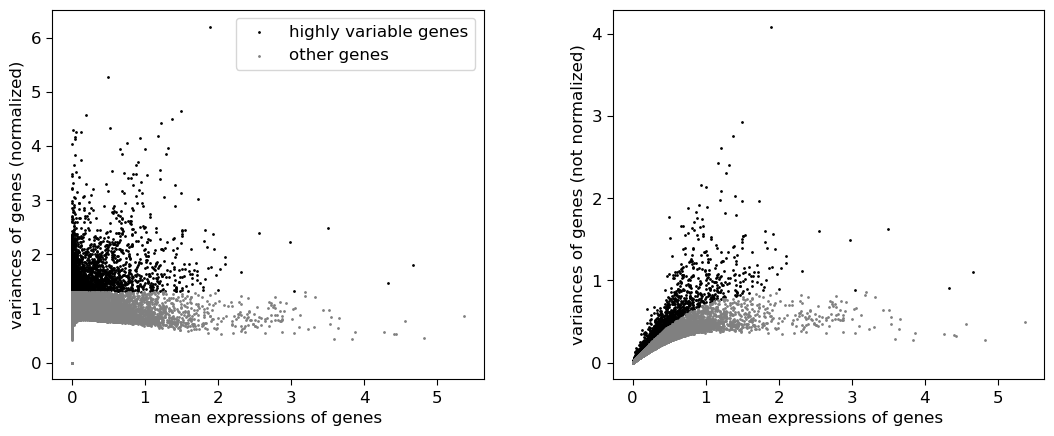

In [283]:
print(f"number of variable genes is: {var_features}")
sc.pl.highly_variable_genes(adata)

# Clustering 

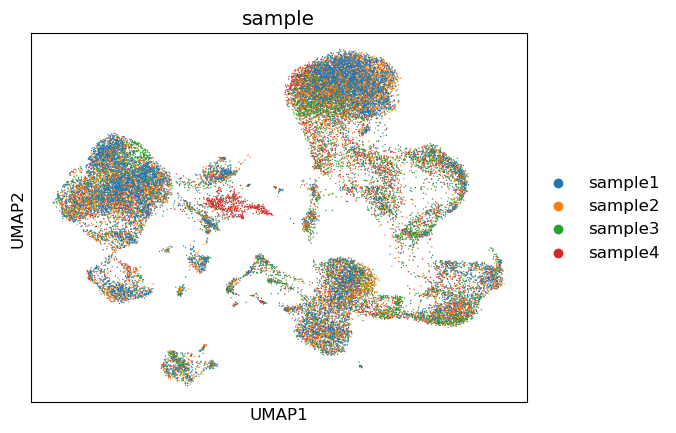

In [284]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [285]:
# If the min_range is 0, skip the first round and start from 0 + step.
min_range = CLUSTERING_RANGE[0] if CLUSTERING_RANGE[0] > 0 else CLUSTERING_RANGE[0] + CLUSTERING_RANGE[2]
max_range = CLUSTERING_RANGE[1]
step = CLUSTERING_RANGE[2]

for i in np.arange(min_range, max_range, step):
    resolution = np.around(i, decimals=3)
    sc.tl.leiden(adata=adata, key_added = f"leiden_{resolution}", resolution=resolution)

## Showing all clustering solution

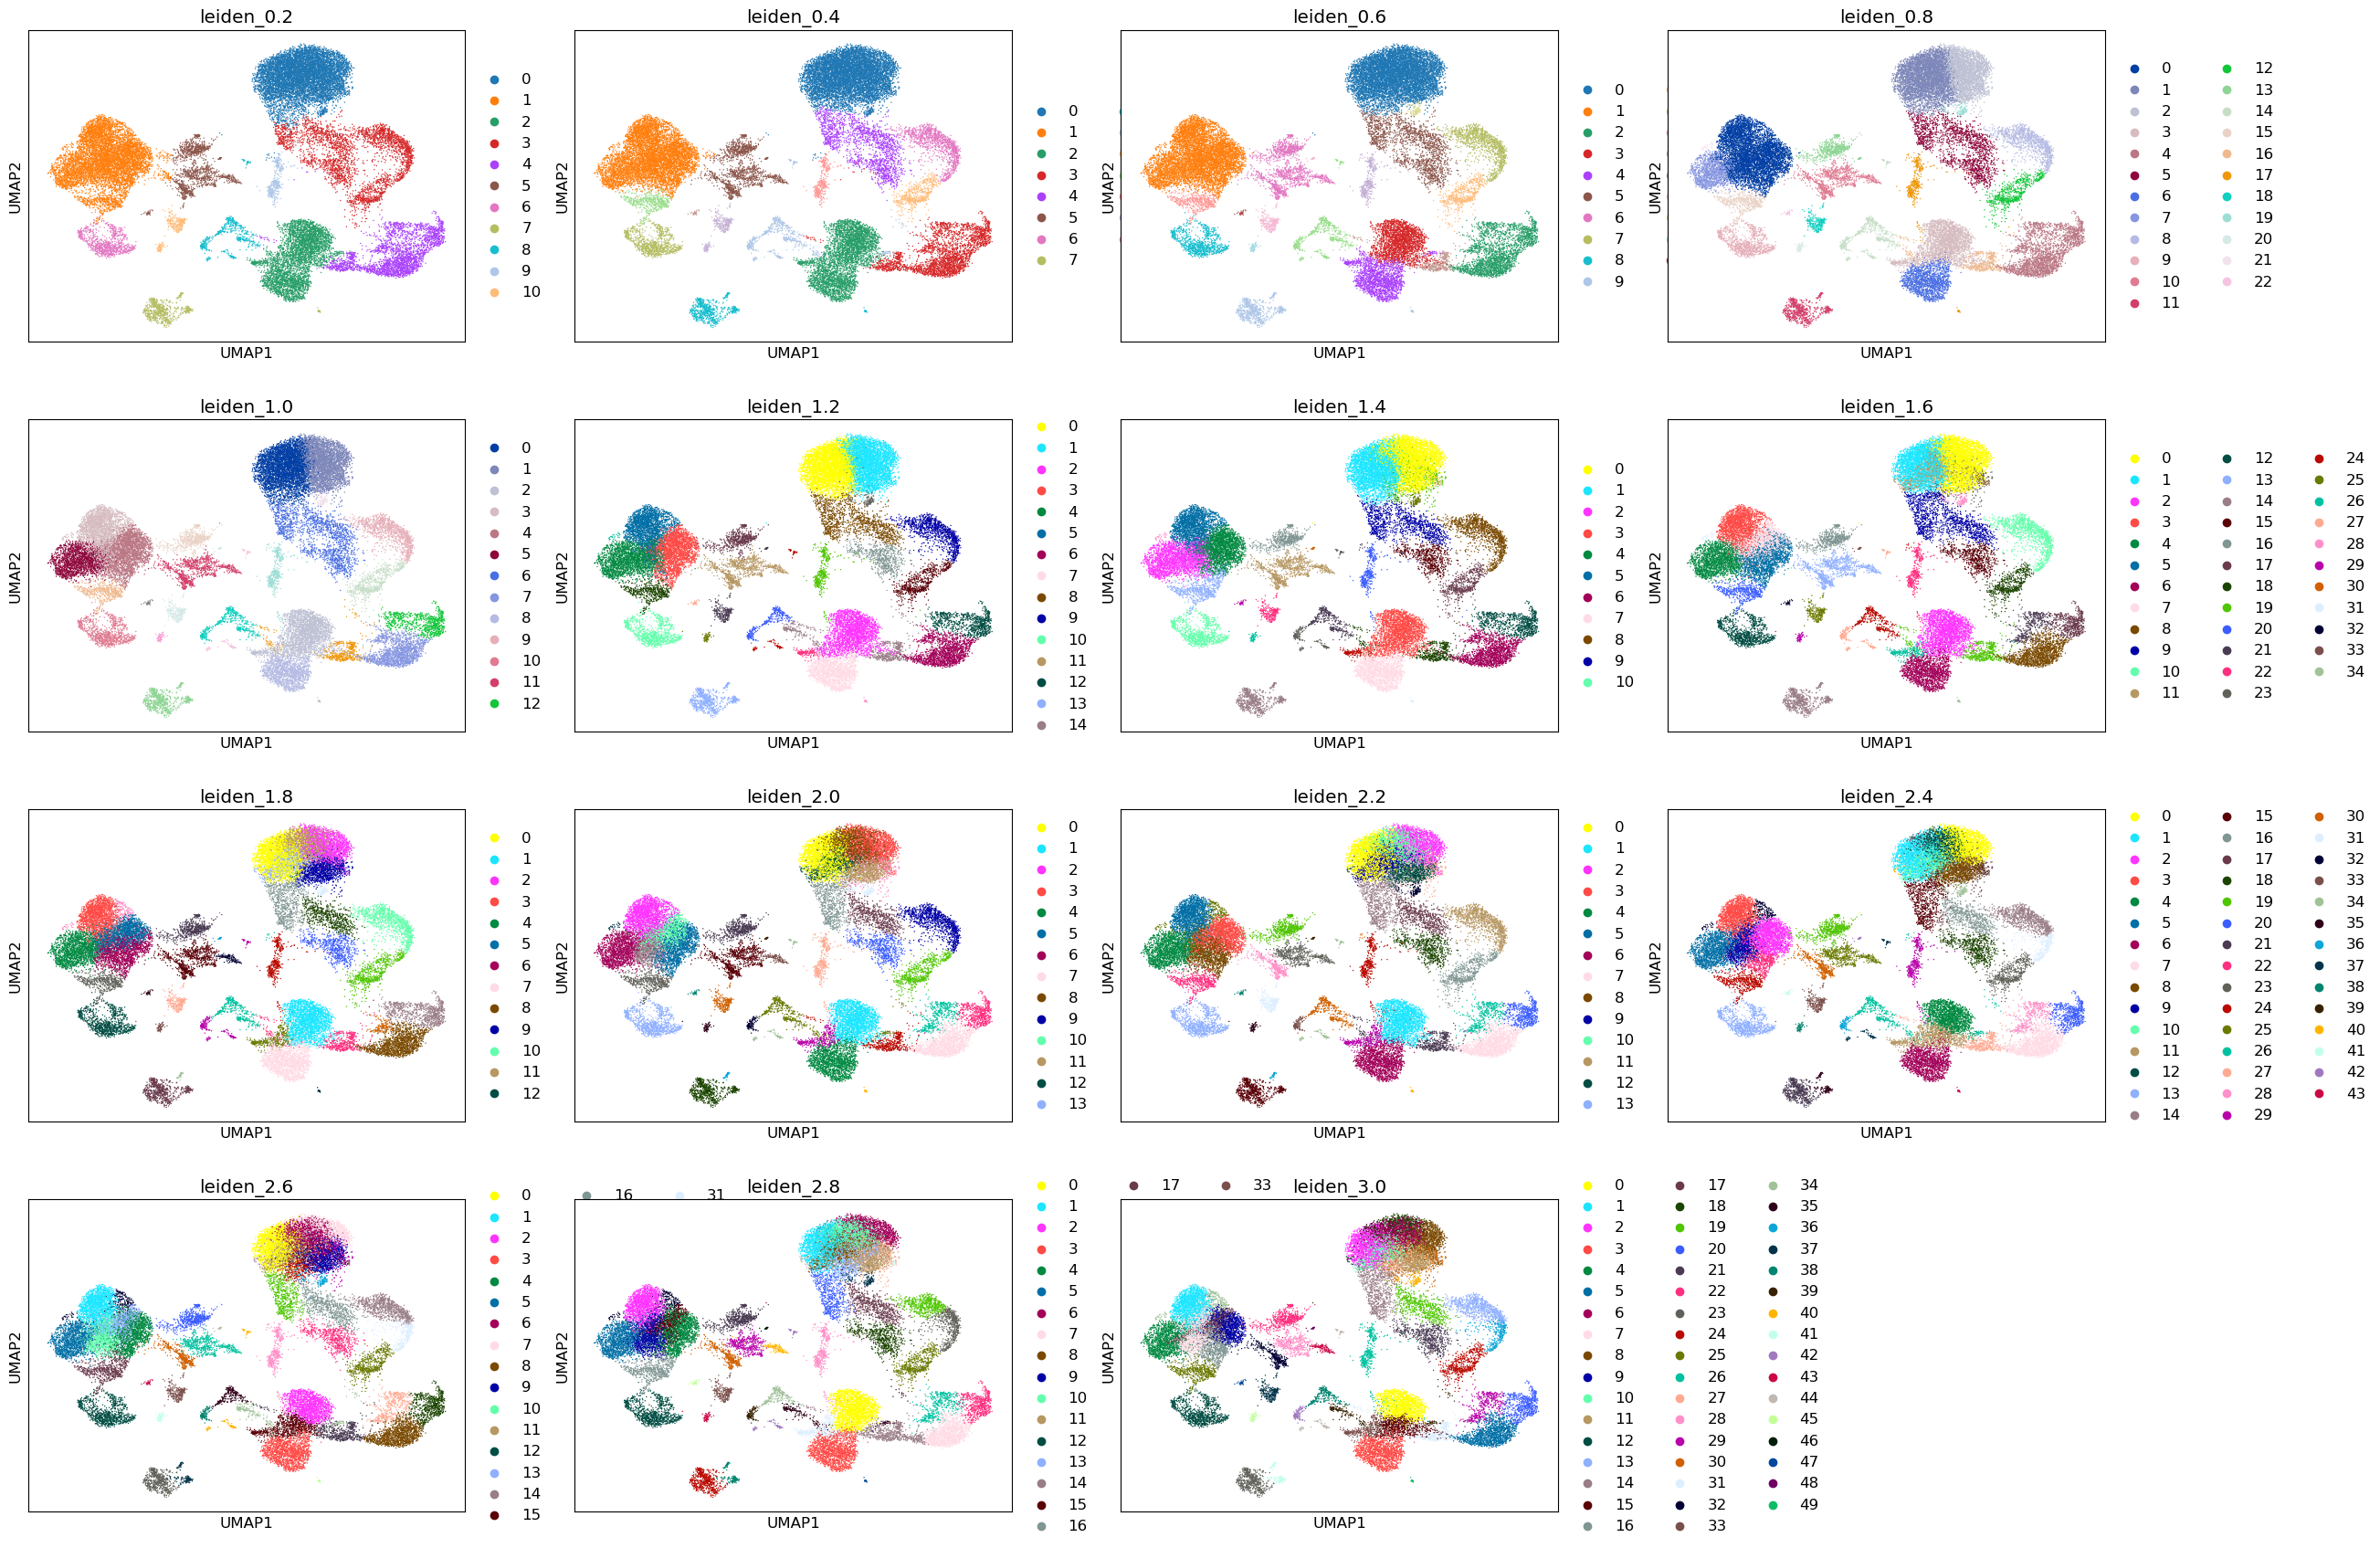

In [287]:
sc.pl.umap(adata, color=adata.obs.filter(regex= "leiden_").columns)

## Clustering Metrics

### Clustree

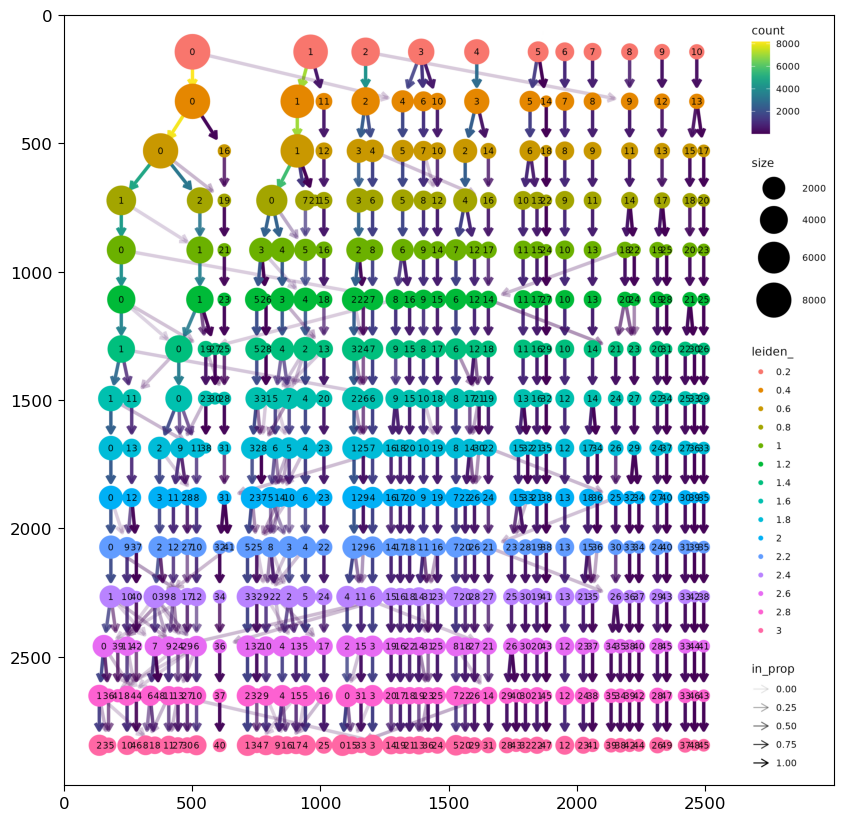

In [286]:
with TemporaryDirectory(dir=".") as f:
    input_dir = path.join(f, "leiden_clusters.csv")
    df = adata.obs.filter(regex= "leiden_")
    df.to_csv(input_dir)
    system(f"Rscript ./utils/clustree.R -i {input_dir} -p leiden_ -o {f}")
    fig = plt.imread(path.join(f, "clustree.png"))

with rc_context({"figure.figsize": (10,10)}):
    plt.imshow(fig)


In [288]:
# Source: https://evafast.github.io/blog/2019/06/28/example_content/

ig_obj = sc.Neighbors(adata).to_igraph()
results_df = pd.DataFrame(columns=['resolution','number_of_clusters',"modularity", 'davies_bouldin_score'])

for col in adata.obs.filter(regex= "leiden_").columns:
    modularity_index = ig_obj.modularity(adata.obs[col].values.astype("int32"))
    davies_bouldin_avg = davies_bouldin_score(adata.obsm['X_pca'], adata.obs[col])
    df = pd.DataFrame([[col,
                    max(adata.obs[col].values.astype("int32")),
                    davies_bouldin_avg,
                    modularity_index]
                    ]
                    , 
                    columns=['resolution','number_of_clusters', 'davies_bouldin_score', "modularity"]
                    )

    results_df = pd.concat([results_df, df])
results_df = results_df.reset_index()


results_df

### Modularity 

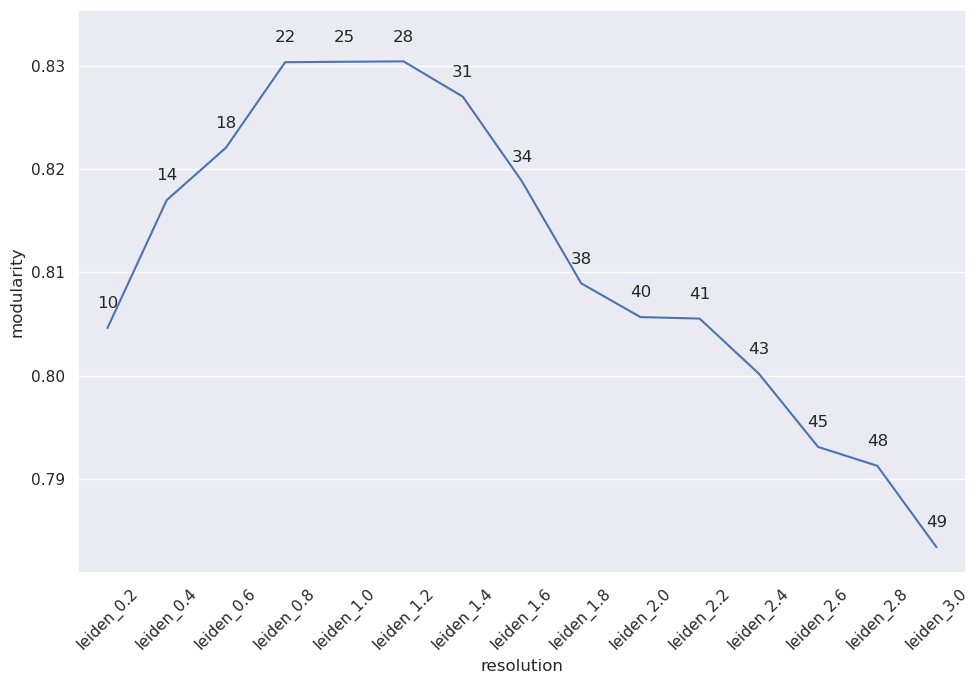

In [289]:
g = (
so.Plot(results_df, "resolution", "modularity", text = "number_of_clusters")
.add(so.Line())
.add(so.Text(), so.Shift(x=0.0, y = 0.0025))
).theme({"figure.figsize": (10,7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

### davies_bouldin_score

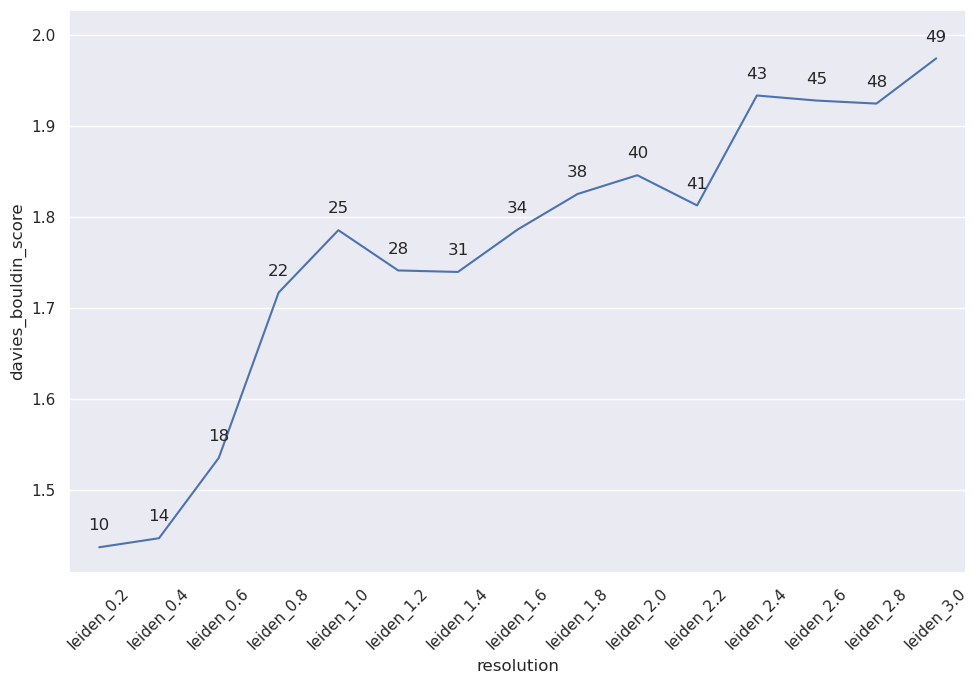

In [290]:
g = (
so.Plot(results_df, "resolution","davies_bouldin_score", text = "number_of_clusters")
.add(so.Line())
.add(so.Text(), so.Shift(x=0.0, y = 0.025))
).theme({"figure.figsize": (10,7)})

fig = g.plot()._figure
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=45)
fig

In [ ]:
# Over-ride the FINAL_RESOLUTION 
# FINAL_RESOLUTION = xx

if FINAL_RESOLUTION > 0:
    adata.uns["clustering_resolution"] = float(FINAL_RESOLUTION)
    sc.tl.leiden(adata, key_added="cluster", resolution= FINAL_RESOLUTION)
else:
    #TODO: Add a logger entry that the final_cluster resolution was not set. 
    pass
    

,index,resolution,number_of_clusters,modularity,silhouette_score,davies_bouldin_score
0,0,leiden_0.2,10,0.804604,NaN,1.437358
1,0,leiden_0.4,14,0.817001,NaN,1.447289
2,0,leiden_0.6,18,0.822080,NaN,1.535520
3,0,leiden_0.8,22,0.830365,NaN,1.716892
4,0,leiden_1.0,25,0.830412,NaN,1.785427
5,0,leiden_1.2,28,0.830449,NaN,1.741231
6,0,leiden_1.4,31,0.827031,NaN,1.739573
7,0,leiden_1.6,34,0.818808,NaN,1.786211
8,0,leiden_1.8,38,0.808932,NaN,1.825129
9,0,leiden_2.0,40,0.805663,NaN,1.845753


In [ ]:
adata = adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session information

In [ ]:
session_info.show()